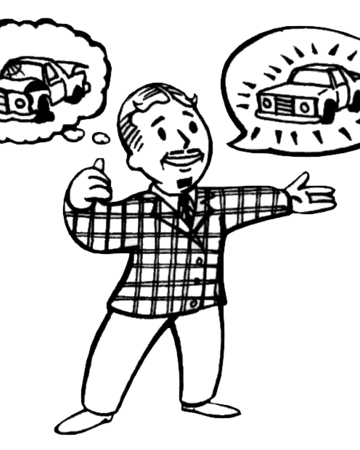

## Проект 5. Выбираем авто выгодно
### Модуль по скачке и парсингу тренировочных данных
#### Для вдохновления пользовался (с большой признательностью)
 - Решением парсинга от команды Almira & Andrey & Sokolov
 - https://github.com/DarkLabel1/YouTube/blob/master/Auto_ru.py
 - Распараллеливанием от Oleg Zyablov (из слака)
---
#### Библиотеки и общие параметры
 - Москва и область (до 200 км. от Москвы);
 - Без ограничений по годам;
 - Только машины марки БМВ;
 - Берём как новые, так и подержаные машины;
 - Цена в рублях;
 - Только европейские или японские.

In [1]:
import requests
import json
import pandas as pd
from tqdm.notebook import tqdm
from time import sleep
from joblib import Parallel, delayed
from fake_useragent import UserAgent

# from bs4 import BeautifulSoup
# from pprint import pprint
# 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA', 'LEXUS', 'SKODA', 'AUDI', 'HONDA', 'VOLVO', 'VOLKSWAGEN', 'MITSUBISHI'   # Марки машин, которые мы собираем
# mark = 'BMW'
# model = 'M6'

url = 'https://auto.ru/-/ajax/desktop/listing/' #URL на который будет отправлен запрос
geo_id = 213       # Москва
geo_radius = 200   # Радиус вокруг Москвы = 200 км
top_days = 900     # кол-во дней от текущей даты назад за которые запрашиваем объявления
brands = ['BMW']
pages = [p for p in range(1, 100)]      # Список страниц


# Заголовок, чтобы прикинуться для авто.ру обыкновенным браузером :)
headers = {
            'Accept': '*/*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3',
            'Connection': 'keep-alive',
            'Content-Length': '1',
            'content-type': 'application/json',
            'Cookie': 'autoru_gdpr=1; _csrf_token=df8af3435de0ea5dd1a651b8e7bde1b6fd5e57945e0b0c6c; autoru_sid=a%3Ag5fbb74172s09isaetrjhu8dm1u2i34n.e5e6d790aa018577bf6fe2204db99922%7C1606399360788.604800.iJDFaWTnL3xaBCbH6Hq12g.Ez-LtkuYJIEQRqZQHbk_cZIb7VqnmqvL4xuTrMVd8Ks; autoruuid=g5fbb74172s09isaetrjhu8dm1u2i34n.e5e6d790aa018577bf6fe2204db99922; suid=25f62e6da872ddff530e9708562c27e5.dcedbe7f9ffbd4bbaae4ab58654037f4; from_lifetime=1606400400961; from=direct; X-Vertis-DC=myt; crookie=H+q+QeAJ+vTboOrv6vXvSnjly5j/a0TsuShfkPV9bL0hHQw0GWMdFTJBYUyIkX86W280FlyhX4uJGYhFkYgOXDvtY5M=; cmtchd=MTYwNjM5MDMwMDYzMw==; yandexuid=9774671561572616848; bltsr=1; navigation_promo_seen-recalls=true',
            'Host': 'auto.ru',
            'origin': 'https://auto.ru',
            'User-Agent': UserAgent().chrome,
            'x-csrf-token': 'df8af3435de0ea5dd1a651b8e7bde1b6fd5e57945e0b0c6c'
}

s = requests.Session()

In [2]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'
}

dict_steering = {'RIGHT': 'Правый',
                 'LEFT': 'Левый'
}

dict_transmission = {'AUTOMATIC': 'автоматическая',
                     'MECHANICAL': 'механическая',
                     'ROBOT': 'роботизированная'
}

dict_pts = {'ORIGINAL': 'Оригинал',
            'DUPLICATE': 'Дубликат'
}

dict_owners = {3: '3 или более',
               2: '2\xa0владельца',
               1: '1\xa0владелец'
}


def replace_str_from_dict(search_term, search_dict):
    '''
    Функция, которая замещает полученный код, значением из словаря.
    Используется для приведения данных к одинаковому виду с тем,
    который имеется в тестовом наборе данных.
    '''
    try:
        for find, replace in search_dict.items():
            if search_term == find:
                return replace
            
    except:
        return search_term
    
    return search_term

In [3]:
def parse_features(offer):
    '''
        Функция, которая парсит полученный JSON, и на выходе возвращает словарь с 1 записью.
        Параметр offer - отвечает за отдельную JSON единицу записи со страницы с объявлениями.
    '''
    
    dict_values = {}

    try: dict_values['bodyType'] = offer['vehicle_info']['configuration']['human_name'].lower()
    except: dict_values['bodyType'] = None

    try: dict_values['brand'] = offer['vehicle_info']['mark_info']['code']
    except: dict_values['brand'] = None

    try: dict_values['color'] = replace_str_from_dict(offer['color_hex'], dict_color)
    except: dict_values['color'] = None

    try: dict_values['fuelType'] = offer['lk_summary'].split()[-1]
    except: dict_values['fuelType'] = None

    try: dict_values['modelDate'] = offer['vehicle_info']['super_gen']['year_from']
    except: dict_values['modelDate'] = None

    try: dict_values['name'] =  offer['vehicle_info']['tech_param']['human_name']
    except: dict_values['name'] = None

    try: dict_values['numberOfDoors'] = offer['vehicle_info']['configuration']['doors_count']
    except: dict_values['numberOfDoors'] = None

    try: dict_values['productionDate'] = offer['documents']['year']
    except: dict_values['productionDate'] = None

    try: dict_values['vehicleTransmission'] = replace_str_from_dict(offer['vehicle_info']['tech_param']['transmission'], dict_transmission)
    except: dict_values['vehicleTransmission'] = None

    try: dict_values['engineDisplacement'] = round(offer['vehicle_info']['tech_param']['displacement'] / 1000, 1)
    except: dict_values['engineDisplacement'] = None

    try: dict_values['vehicleConfiguration'] =  offer['vehicle_info']['configuration']['body_type']+' '+\
                                                offer['vehicle_info']['tech_param']['transmission']+' '+\
                                                str(dict_values['engineDisplacement'])
    except: dict_values['vehicleConfiguration'] = None

    try: dict_values['enginePower'] = offer['vehicle_info']['tech_param']['power']
    except: dict_values['enginePower'] = None

    try: dict_values['description'] = offer['description']
    except: dict_values['description'] = None

    try: dict_values['mileage'] = offer['state']['mileage']
    except: dict_values['mileage'] = None

    try: dict_values['complectation_dict'] = offer['vehicle_info']['complectation']
    except: dict_values['complectation_dict'] = None

    try: dict_values['Привод'] = offer['lk_summary'].split(', ')[-2]
    except: dict_values['Привод'] = None

    try: dict_values['Руль'] = replace_str_from_dict(offer['vehicle_info']['steering_wheel'], dict_steering)
    except: dict_values['Руль'] = None

    try: dict_values['Состояние'] = (lambda x: 'Не требует ремонта' if x == True else 'Битая')(offer['state']['state_not_beaten'])
    except: dict_values['Состояние'] = None

    try: dict_values['Владельцы'] = replace_str_from_dict(offer['documents']['owners_number'], dict_owners)
    except: dict_values['Владельцы'] = None

    try: dict_values['ПТС'] = replace_str_from_dict(offer['documents']['pts'], dict_pts)
    except: dict_values['ПТС'] = None

    try: dict_values['Таможня'] = (lambda x: 'Растаможен' if x == True else 'Не растаможен')(offer['documents']['custom_cleared'])
    except: dict_values['Таможня'] = None

    try: dict_values['Владение'] =  offer['documents']['purchase_date']
    except: dict_values['Владение'] = None

    try: dict_values['price'] = offer['price_info']['RUR']
    except: dict_values['price'] = None

    try: dict_values['model_info'] = offer['vehicle_info']['model_info']
    except: dict_values['model_info'] = None

    try: dict_values['model_name'] = offer['vehicle_info']['model_info']['code']
    except: dict_values['model_name'] = None

    try: dict_values['equipment_dict'] = offer['vehicle_info']['equipment']
    except: dict_values['equipment_dict'] = None

    try: dict_values['super_gen'] = offer['vehicle_info']['super_gen']
    except: dict_values['super_gen'] = None
        
    try: dict_values['vendor'] = offer['vehicle_info']['vendor']
    except: dict_values['vendor'] = None

    try: dict_values['sell_id'] = offer['id']
    except: dict_values['sell_id'] = None

    return dict_values

In [4]:
def download_data(brand):
    '''
        Функция, которая сгружает все данные с объявлениями Авто.ру по конкретной марке автомобиля
        и записывает в файл csv полученные данные (отдельный файл для каждой марки).
        Параметр brand: марка автомобиля в написании как на Авто.ру
        Функция также пользуется глобальными значениями определяющими место, для которого ищутся
        объявления (по умолчанию Мск + область в радиусе 200 км) и кол-во дней истории (900).
    '''
    df = pd.DataFrame()

    for page in tqdm(pages):

        param = {
                'catalog_filter': [{'mark': brand}], #, 'model': model
                'section': 'all',
                'category': 'cars',
                'sort': 'fresh_relevance_1-desc',
                'geo_radius': geo_radius,
                'geo_id': geo_id,
                'page': page,
                'top_days': top_days
        }

        response = s.post(url, json=param, headers=headers)
        
        try:
            offers = response.json()['offers']
        except:
            offers = None

        if response.status_code == 200 and len(offers) > 0:

            for i in range(len(offers)):
                df = df.append(parse_features(offers[i]), ignore_index=True)

            sleep(0.5)

    return df

In [5]:
data = pd.DataFrame()

data = data.append(Parallel(n_jobs = 5)(delayed(download_data)(brand) for brand in brands), ignore_index=True)

data.to_csv('train.csv', index=False)
print(f'Записал в файл {len(data)} строк данных.')

print('All done!')

Записал в файл 3674 строк данных.
All done!


In [6]:
# Отладочная ячейка

# from pprint import pprint

# param = {
#         'catalog_filter': [{'mark': 'BMW'}], #, 'model': model
#         'section': 'all',
#         'category': 'cars',
#         'sort': 'fresh_relevance_1-desc',
#         'geo_radius': geo_radius,
#         'geo_id': geo_id,
#         'page': 1,
#         'top_days': top_days
# }

# response = s.post(url, json=param, headers=headers)

# pprint(parse_features(response.json()['offers'][0]))

# pprint(response.json()['offers'][0]['vehicle_info']['tech_param']['transmission'])